# Step 1: Network Filtering and Processing
---
Run this code block by block to convert a street network in ESRI Shapefile, GeoJSON, or GeoPackage format into a routable and conflated network graph to use in BikewaySim.

Three networks were used in this project. While code to obtain OSM GeoJSONs has been included with downloading OSM notebook, the ABM and HERE networks need to be sourced from the Atlanta Regional Commission and HERE respectively.

#### Import Modules

In [4]:
from pathlib import Path
import geopandas as gpd
from network_filter import *

# General Settings Dictionary
---
The only input needed for this code is the project directory and the settings dictionary. The settings dictionary has 6 inputs that are commented out below. Note that subsequent code blocks were used for other runs, and should be left commented out so it doesn't overwrite the settings dictionary.

In [5]:
# GDOT BikewaySim Project
project_dir = Path.home() / 'Downloads/cleaned_trips/networks'

settings = {
    'output_fp': project_dir,
    'crs': "EPSG:2240",
    'studyarea_fp': Path.home()/'Documents/NewBikewaySimData/Data/Study Areas/itp.gpkg',
    'studyarea_layer': None,
    'use_bbox': False
}

# #NCST TransitSim Project Bike Portion
# project_dir = Path.home() / 'Documents/NewBikewaySimData'

# settings = {
#     'output_fp': project_dir, #where new folder with studyarea name containing the filtered network files will output
#     'crs': "EPSG:2240", # project all spatial data to this CRS
#     'studyarea_fp': project_dir / 'Data/Study Areas/bikewaysim_studyarea.geojson', # set the filepath for the study area
#     'studyarea_name': 'bikewaysim', # set a name to create a new directory in the project directory
#     'studyarea_layer': None, # replace with study area layer name if file is a gpkg or gdb, otherwise put None
#     'use_bbox': False # use bounding box instead of studyarea polygon boundaries as mask for importing links
# }

#NCST TransitSim Project Transit Portion
# project_dir = Path.home() / 'Documents/TransitSimData/networks'

# settings = {
#     'output_fp': project_dir,
#     'crs': "EPSG:2240",
#     'studyarea_fp': Path.home() / 'Documents/TransitSimData/Data/base_layers.gpkg',
#     'studyarea_layer': 'studyarea',
#     'use_bbox': True
# }

# #ITS4US Gwinnett
# project_dir = Path.home() / 'Documents/NewBikewaySimData'

# settings = {
#      'output_fp': project_dir, #where filtered network files will output
#      'crs': "EPSG:2240", # project all spatial data to this CRS
#      'studyarea_fp': project_dir / 'Data/Study Areas/ITS4US_StudyBoundary.shp', # fp for the study area
#      'studyarea_name': 'its4us',
#      'studyarea_layer': None, #replace with study area layer name if file is gpkg or gdb
#      'use_bbox': False # use bounding box instead of studyarea polygon boundaries as mask for importing links
# }

# #Rachael Strava
# project_dir = Path.home() / 'Downloads/Rachael'

# settings = {
#      'output_fp': project_dir, #where filtered network files will output
#      'crs': "EPSG:2240", # project all spatial data to this CRS
#      'studyarea_fp': project_dir / "all_edges_hourly_2022-05-01-2022-05-31_ride/f48e07a8511045e74b10f4cd956750e64fe056d0404b475acfb91919af3e6180-1686749935887.shp", # fp for the study area
#      'studyarea_name': 'strava2',
#      'studyarea_layer': None, #replace with study area layer name if file is gpkg or gdb
#      'use_bbox': True # use bounding box instead of studyarea polygon boundaries as mask for importing links
# }


#### Import study area:
Specify what area you want to mask the network data by. Only network links that are partially or fully within the study area will be imported. Note: network links are NOT clipped (because this cuts off nodes).

The study area is 251.23 square miles.


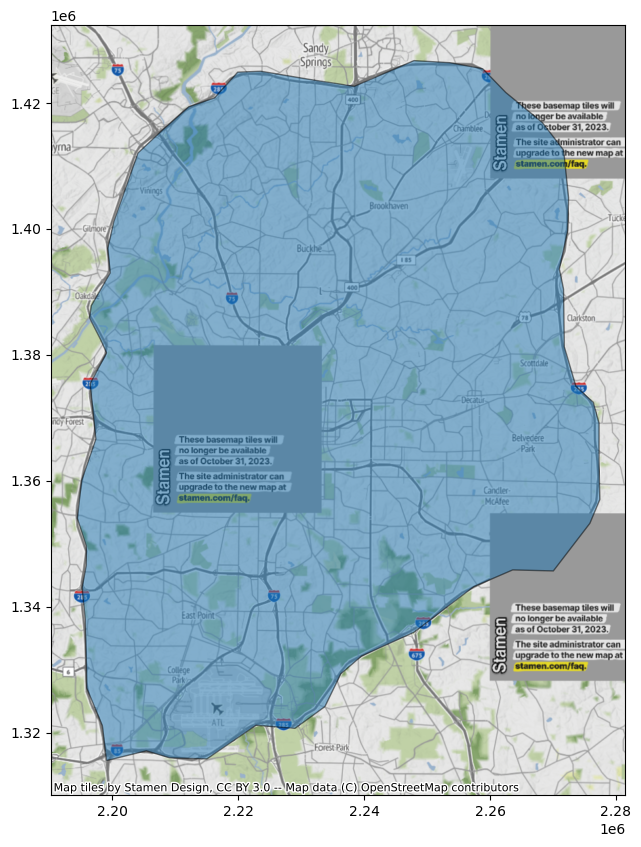

In [6]:
#Adds study area geodataframe to settings dictionary
settings['studyarea'] = import_study_area(settings)

# Run Network Filter Module to Create General, Road, Bike, and Service Layers
---
From the network_filter.py file run the filter networks function. This will first import the spatial data and then filter the data into a raw, general, road, bike, and serivce layer as long as the filters have been pre-defined within the respective function within 'network_filter.py.'

**Note: If this is the a new network that is not OSM, HERE, or ABM then specify a new filter method by going into the 'network_filter.py' script. Otherwise, none of the links will be filtered into road/bike/service layers.**

**Imported networks will be projected to CRS defined in the settings dictionary**

When entering a new filter, search for the following functions: 'filter_to_general', 'filter_to_road', 'filter_to_bike', and 'filter_to_service.' Then add the network name as a new if statement.

If the filters have been specified (by default there are filters for networks that are named 'osm', 'here', and 'osm') then fill in the dictionary and run the 'filter_networks' function with settings dictionary and network dictionary. The network dictionary has the following keys.

- 'network_name': text name of the network (by defualt accepts 'abm','here','osm')
- 'links_fp': the filepath of the original links network data (must have a value)
- 'links_layer': if the file is a geopackage or geodatabase then use this to specify the layer to import
- 'nodes_fp': the filepath of the nodes data if available (replace with None if not available)
- 'nodes_layer': if the file is a geopackage or geodatabase then use this to specify the layer to import
- 'nodes_id': indicates the column name that contains the unique ids for each node (replace with None if not available)
- 'A': indicates the starting node id column name for the links (replace with None if not available)
- 'B': indicates the ending node id column name for the links (replace with None if not available)

## OpenStreetMap (OSM) Filtering
---
OSM is an open-source mapping project (see www.openstreetmap.org). OSM network data can be downloaded using the "Step 0 Downloading OSM.ipynb" Jupyter Notebook.

#### General Layer Filtering
- Remove interstates and interstate ramps (highway = motorway | motorway_link)
- Remove sidewalks unless bicycles explicitly allowed (footway = sidewalk | crossing unless bicycle = yes)

#### Road Layer Filtering
- Keep service roads that have a street name (highway = service and name is not null)
- Keep links with the following keys for the highway tag: 'primary','primary_link','residential','secondary','secondary_link','tertiary','tertiary_link','trunk','trunk_link'

#### Bike Layer Filtering
- Include links with the following keys for the 'highway' tag: 'cycleway','footway','path','pedestrian','steps'

#### Service Layer Filtering
- Include links with the key of 'service' for the 'highway' tag unless they have a name


In [7]:
osm = {
       "network_name": 'osm',
       "links_fp": project_dir / "osm.gpkg", 
       "links_layer":"links", 
       "nodes_fp": project_dir / "osm.gpkg", 
       "nodes_layer":"nodes",
       "nodes_id": "osmid",
       "A": None,
       "B": None
       }

filter_networks(settings,osm)

Filtering the osm network.
There is a nodes layer...
but no reference ids for links.


c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Reference IDs successfully added to links.
Cleaning measures applied for osm...
osm road filter applied...
nothing happened
osm bike filter applied...
osm service filter applied...
osm imported... took 3.5 minutes


## HERE Filtering
---
HERE is licensed data typically used for logistics.

#### General Layer Filtering
- Remove interstates and interstate ramps (controlled access = yes or ramp = yes) that don't allow bikes

#### Road Layer Filtering
- Keep all links that allow automobile access (ar_auto = yes)
- Remove links with a speed limit < 6 mph (speed_cat = 8) as these are driveways

#### Bike Layer Filtering
- All links that do not allow auto access (ar_auto = no)

#### Service Layer Filtering
- All links that allow auto access with a speed limit < 6mph (ar_auto = y and speed_cat = 8)


In [8]:
here = {
       "network_name": 'here', # name for network
       "links_fp": Path.home() / 'Documents/NewBikewaySimData/Data/HERE/Streets.shp', #filepath for the links
       "links_layer":None, # layer name for links if gpkg or gdb
       "nodes_fp": None, # if there is not a nodes file put None
       "nodes_layer": None, # layer name for nodes if gpkg or gdb (put none if no nodes)
       "nodes_id": None, # column name of node id (put none if no node id)
       "A": "REF_IN_ID", # starting node id reference column on links (put none if no reference links)
       "B": "NREF_IN_ID" # starting node id reference column on links (put none if no reference links)
       }

filter_networks(settings,here)

Filtering the here network.
no nodes layer
but links have reference ids


c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\tpassmore6\Anaconda3\envs\geo-env\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


here road filter applied...
here bike filter applied...
here service filter applied...
here imported... took 2.29 minutes


## ABM Filtering
---
This is the modeling network used in the Atlanta Regional Commission's Activity Based Model. It was provided by the ARC and is available on request.

#### General Layer Filtering
- Remove all links except for principal arterials, minor arterials, collectors, and local roads (FACTYPE = 10, 11, or 14)

#### Road Layer Filtering
- The filtering done in the previous step was enough, no further filtering needed

#### Bike Layer Filtering
- No bike links present

#### Service Layer Filtering
- No service links present

In [9]:
abm = {
       "network_name": 'abm',
       "links_fp": project_dir / 'Data/ARC/rtp_amd6_2030_network.gdb',
       "links_layer":"DAILY_Link",
       "nodes_fp": project_dir / 'Data/ARC/rtp_amd6_2030_network.gdb',
       "nodes_layer":"DAILY_Node",
       "nodes_id": "N",
       "A": "A",
       "B": "B"
       }

filter_networks(settings,abm)

Filtering the abm network.


DriverError: C:\Users\tpassmore6\Downloads\cleaned_trips\networks\Data\ARC\rtp_amd6_2030_network.gdb: No such file or directory

If your network file has layers, you can use this code snippet to print them out:

```
import fiona    
fiona.listlayers()
```

# Summurize filtered networks
---
#### Prints out:
- Number of nodes
- Number of links
- Total length of all links
- Average link length

#### Exports:
- CSV file with all the network statistics.

In [10]:
#summurize networks and export summary as "network_summary.csv in the working directory
#total length in miles and link length in feet
summary(settings)

                   num_links num_nodes tot_link_length avg_link_length
osm_links_raw         204051    155168          7031.0           181.9
osm_links_general     175764    142492          5911.0           177.6
osm_links_road         71489     61814          3276.0           241.9
osm_links_bike         14473     13709           387.0           141.0
osm_links_service      89289     94436          2231.0           131.9
here_links_raw        134048    104042          5514.0           217.2
here_links_general    129706    100250          5084.0           206.9
here_links_road        64897     55609          3324.0           270.4
here_links_bike         7586      7589           191.0           133.2
here_links_service     57223     54769          1568.0           144.7


# Find TAZs within study area
---
Use this block to filter origin-destination data by the study area. For this project TAZs were used.

In [ ]:
# tazs = gpd.read_file(Path.home() / 'Documents/NewBikewaySimData/Data/ARC/Model_Traffic_Analysis_Zones_2020.geojson')[['OBJECTID','geometry']]

# #convert to study area crs
# tazs.to_crs(settings['crs'],inplace=True)

# #get centroids of tazs
# centroids = tazs.copy()
# centroids.geometry = tazs.centroid

# #find centroids that are within the study area
# centroids = centroids[centroids.geometry.within(settings['studyarea']['geometry'].item())]

# #filter tazs
# tazs = tazs[tazs['OBJECTID'].isin(centroids['OBJECTID'])]

# #export
# centroids.to_file(Path.home() / "Documents/NewBikewaySimData" / settings['studyarea_name'] / "base_layers.gpkg",layer='centroids')
# tazs.to_file(Path.home() / "Documents/NewBikewaySimData" / settings['studyarea_name'] / "base_layers.gpkg",layer='tazs')
